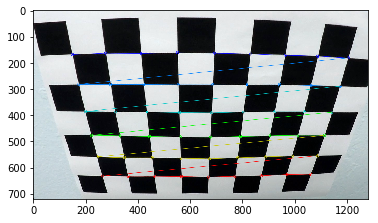

In [2]:
#Calibrating the camera
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# prepare object points
nx = 9 #TODO: enter the number of inside corners in x
ny = 6 #TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = './camera_cal/calibration2.jpg'
img = cv2.imread(fname)

# Convert to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# Find the chessboard corners
ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

# If found, draw corners
if ret == True:
    # Draw and display the corners
    cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    plt.imshow(img)


In [3]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
import glob

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

#print(" objp = ",objp)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #write_name = 'corners_found'+str(idx)+'.jpg'
        #cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
    else :
        print("Not used- ",fname)

cv2.destroyAllWindows()

Not used-  camera_cal\calibration1.jpg
Not used-  camera_cal\calibration4.jpg
Not used-  camera_cal\calibration5.jpg


(720, 1280)


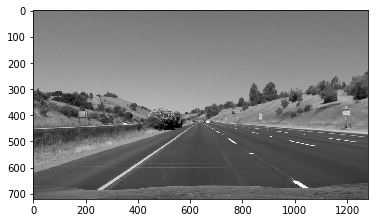

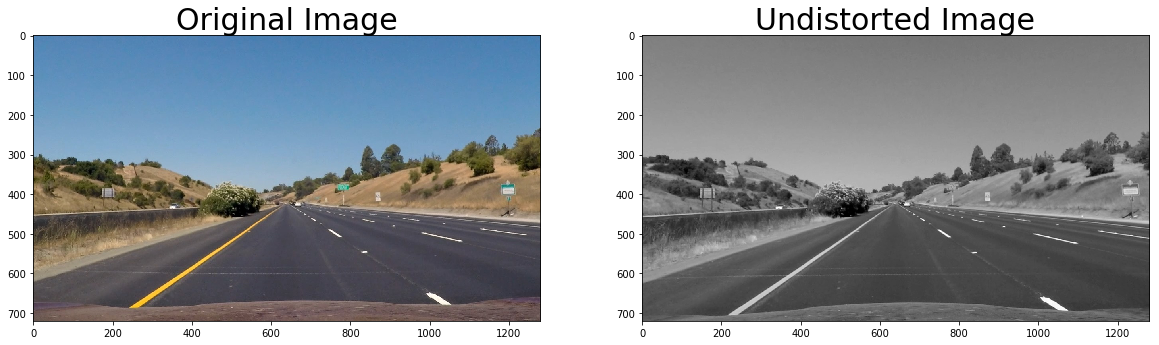

In [4]:
import pickle
img = mpimg.imread('test_images/straight_lines1.jpg')
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap = 'gray')
print(gray.shape)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

undistorted = cv2.undistort(gray, mtx, dist, None, mtx)
cv2.imwrite('output_images/test_undist.jpg',undistorted)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump( dist_pickle, open( "output_images/wide_dist_pickle.p", "wb" ) )
#dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(img, cmap = 'gray')
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(undistorted, cmap = 'gray')
ax2.set_title('Undistorted Image', fontsize=30)

## Perspective Transform

Image shape (720, 1280, 3)
size_y 720
size_x 1280
src.shape (4, 2)
dst.shape (4, 2)


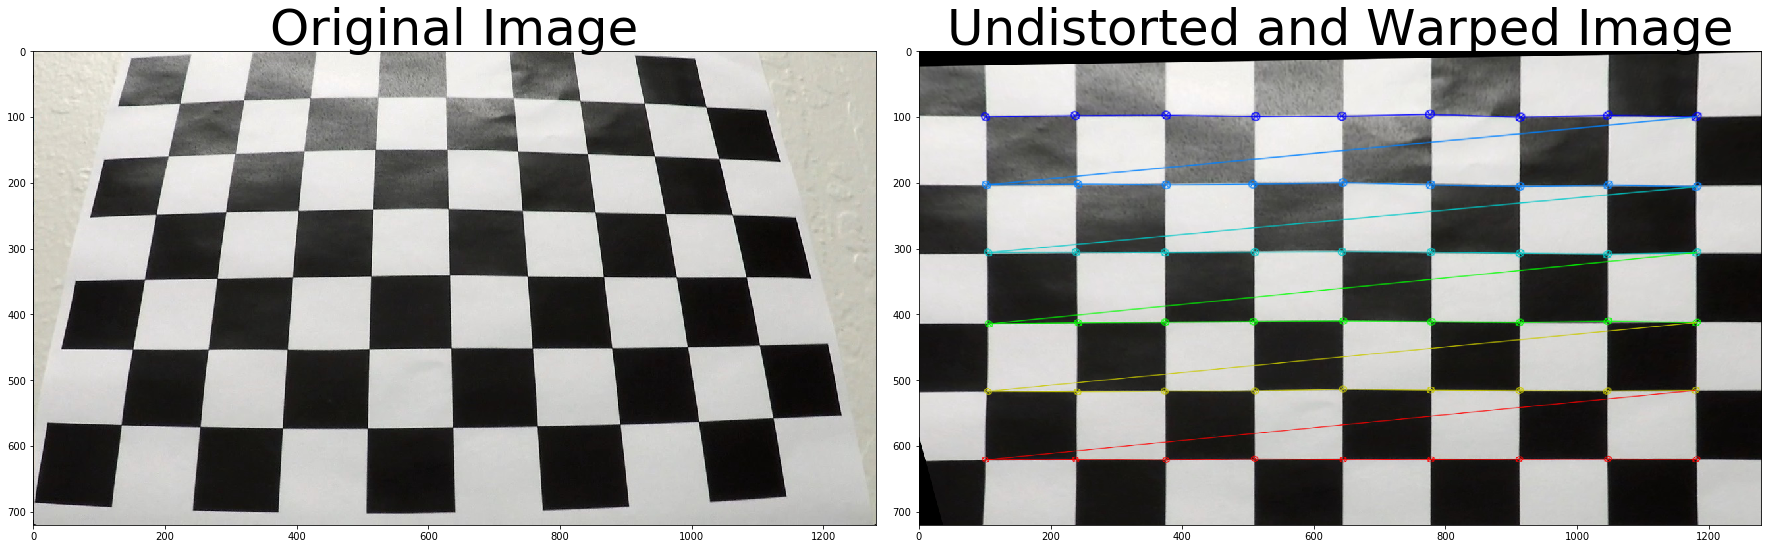

In [5]:
dist_pickle = pickle.load( open( "output_images/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

# Read in an image
img = mpimg.imread('camera_cal/calibration3.jpg')
nx = 9 # the number of inside corners in x
ny = 6 # the number of inside corners in y
print("Image shape", img.shape)
size_y = img.shape[0]
size_x = img.shape[1]
print("size_y",size_y)
print("size_x",size_x)

MARGIN = 100
# MODIFY THIS FUNCTION TO GENERATE OUTPUT 
# THAT LOOKS LIKE THE IMAGE ABOVE
def corners_unwarp(img, nx, ny, mtx, dist):
    # Pass in your image into this function
    # Write code to do the following steps
    # 1) Undistort using mtx and dist
    img = cv2.undistort(img, mtx, dist, None, mtx)
    # 2) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)
    # 4) If corners found: 
            # a) draw corners
            # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
                 #Note: you could pick any four of the detected corners 
                 # as long as those four corners define a rectangle
                 #One especially smart way to do this would be to use four well-chosen
                 # corners that were automatically detected during the undistortion steps
                 #We recommend using the automatic detection of corners in your code
            # c) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
            # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
            # e) use cv2.warpPerspective() to warp your image to a top-down view
    #print(corners)
    if ret== True:
        cv2.drawChessboardCorners(img, (nx,ny), corners,ret)
        # source points
        src = corners[0,0,:]
        src = np.append(src,corners[nx-1,0,:])
        src = np.append(src,corners[nx*ny-nx,0,:])
        src = np.append(src,corners[nx*ny-1,0,:])
        src = src.reshape(-1,2)
        
        #print("src",src)
        
        # destination points
        
        dst = np.float32([[MARGIN,MARGIN],[size_x-MARGIN,MARGIN],[MARGIN,size_y-MARGIN],[size_x-MARGIN,size_y-MARGIN]])
        print("src.shape",src.shape)
        print("dst.shape",dst.shape)
        M = cv2.getPerspectiveTransform(src,dst)
        warped = cv2.warpPerspective(img, M, (size_x,size_y) , flags=cv2.INTER_LINEAR)
        
    return warped, M

top_down, perspective_M = corners_unwarp(img, nx, ny, mtx, dist)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(top_down)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Perspective on Test Image


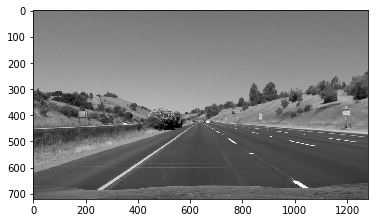

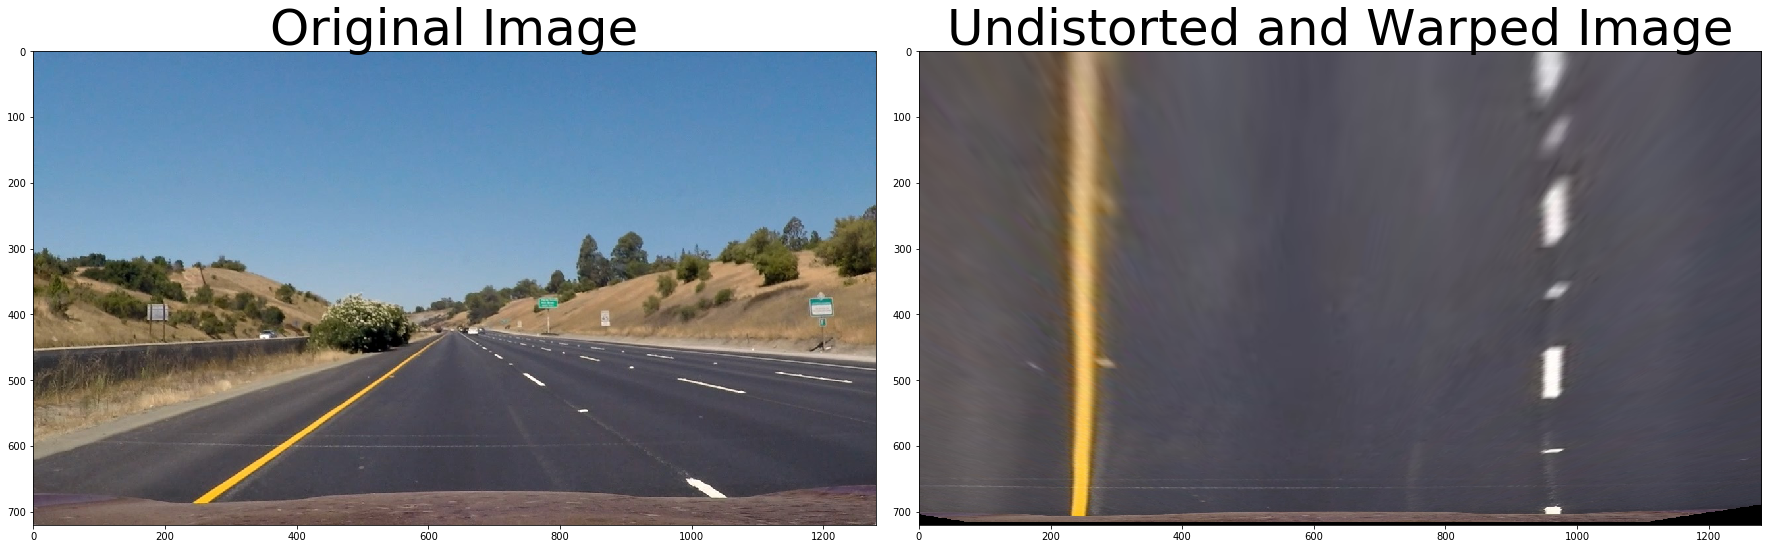

In [6]:
dist_pickle = pickle.load( open( "output_images/wide_dist_pickle.p", "rb" ) )
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]
img = mpimg.imread('test_images/straight_lines1.jpg')
gray  = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
plt.imshow(gray, cmap = 'gray')
#print(img.shape)
src = np.float32([[285,670],[1017,670],[596,450],[683,450]])
dst = np.float32([[250,700],[950,700],[250,0],[950,0]])

M = cv2.getPerspectiveTransform(src,dst)
Minv = cv2.getPerspectiveTransform(src,dst)
warped = cv2.warpPerspective(img, M, (gray.shape[::-1]) , flags=cv2.INTER_LINEAR)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('Undistorted and Warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




In [21]:
# definition
def plot_two_images(img1,img2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img1)
    ax2.imshow(img2, cmap = 'gray')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def rgb_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

def bgr_gray(img):
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)


    

## READ IMAGE HERE

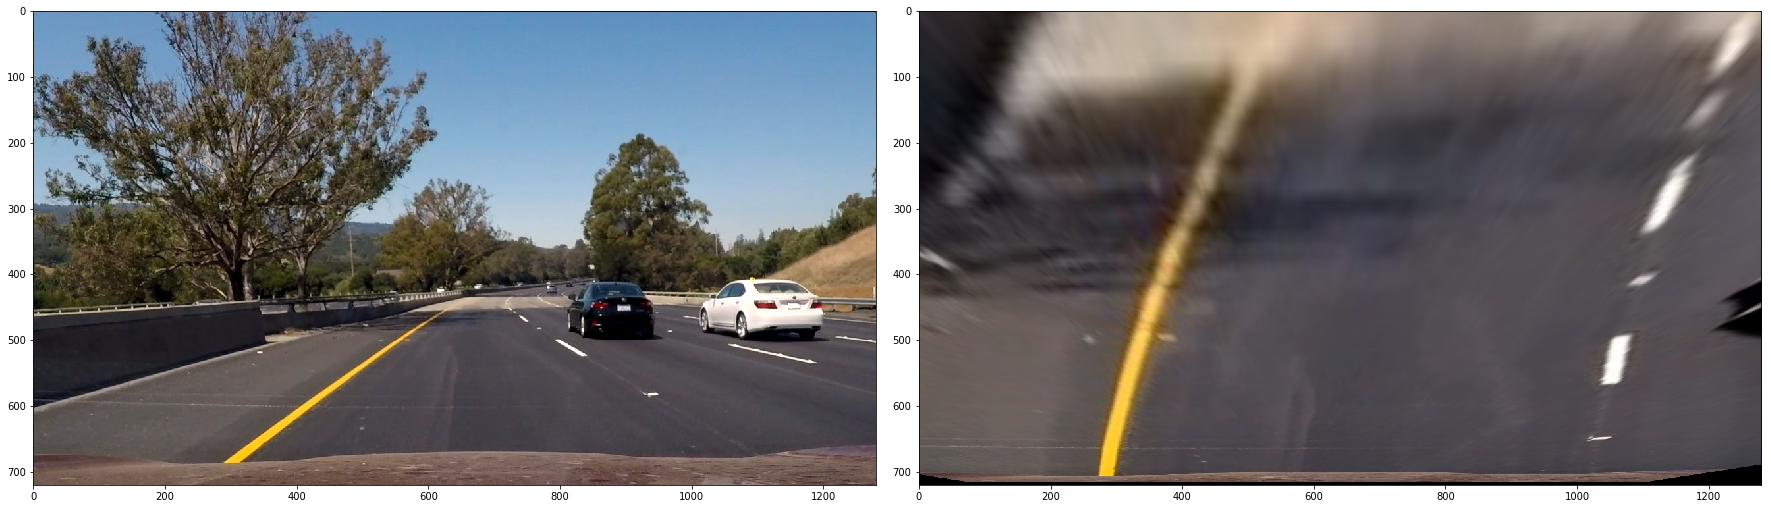

In [205]:
img = mpimg.imread('test_images/test6.jpg')
#img = mpimg.imread('test_images/straight_lines1.jpg')
gray = rgb_gray(img)
warped = cv2.warpPerspective(img, M, (gray.shape[::-1]) , flags=cv2.INTER_LINEAR)

plot_two_images(img, warped)


## Thresholding 


In [48]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0,255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    # 3) Take the absolute value of the derivative or gradient
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x' :
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0,ksize = sobel_kernel)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F,0,1, ksize = sobel_kernel)
    else :
        return None
    
    abs_sobel = np.absolute(sobel)
    
    scaled_sobel = np.uint8(255* (abs_sobel)/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel > thresh[0]) & (scaled_sobel < thresh[1] )] = 1
    
    
        
    #binary_output = np.copy(img) # Remove this line
    return binary_output


In [31]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Calculate the magnitude 
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    # 5) Create a binary mask where mag thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F,0,1)
    
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    abs_sobel = np.sqrt(sobelx**2 + sobely**2  )
    
    scaled_sobel = np.uint8(255* (abs_sobel)/np.max(abs_sobel))
    
    binary_output = np.zeros_like(scaled_sobel)
    
    binary_output[(scaled_sobel > mag_thresh[0]) & (scaled_sobel < mag_thresh[1] )] = 1
    return binary_output

In [129]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    # 2) Take the gradient in x and y separately
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    # 5) Create a binary mask where direction thresholds are met
    # 6) Return this mask as your binary_output image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1,0, ksize = sobel_kernel )
    sobely = cv2.Sobel(gray,cv2.CV_64F, 0,1, ksize = sobel_kernel)
    print("Gray Shape", gray.shape)
    print("Sobel Shape", sobelx.shape)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    binary_output = np.zeros_like(abs_sobelx)
    binary_output[(dir_grad > thresh[0]) & (dir_grad<thresh[1])] = 1

    return binary_output

In [130]:
def hls_threshold(img, color_channel = 's', thresh=(0,255)):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    H = hls[:,:,0]
    L = hls[:,:,1]
    S = hls[:,:,2]
    
    binary = np.zeros_like(S)
    print("max ", np.max(S))
    print("min ", np.min(S))
    
    
    if color_channel == 's':        
        binary[(S > thresh[0]) & (S <= thresh[1])] = 1
        
    elif color_channel == 'h':        
        binary[(H > thresh[0]) & (H <= thresh[1])] = 1
        
    elif color_channel == 'l':        
        binary[(L > thresh[0]) & (L <= thresh[1])] = 1
        
        
    return binary

Gray Shape (720, 1280)
Sobel Shape (720, 1280)


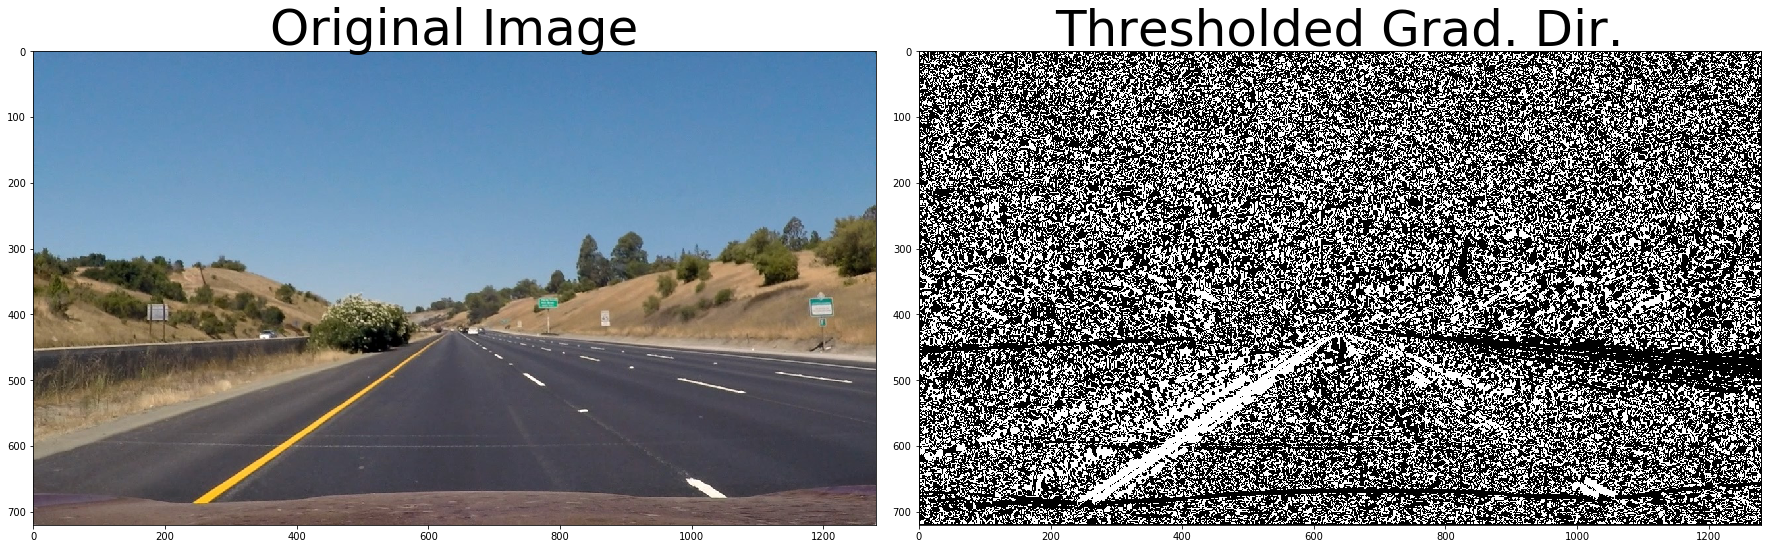

In [37]:
# Run the dir_threshold function
dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

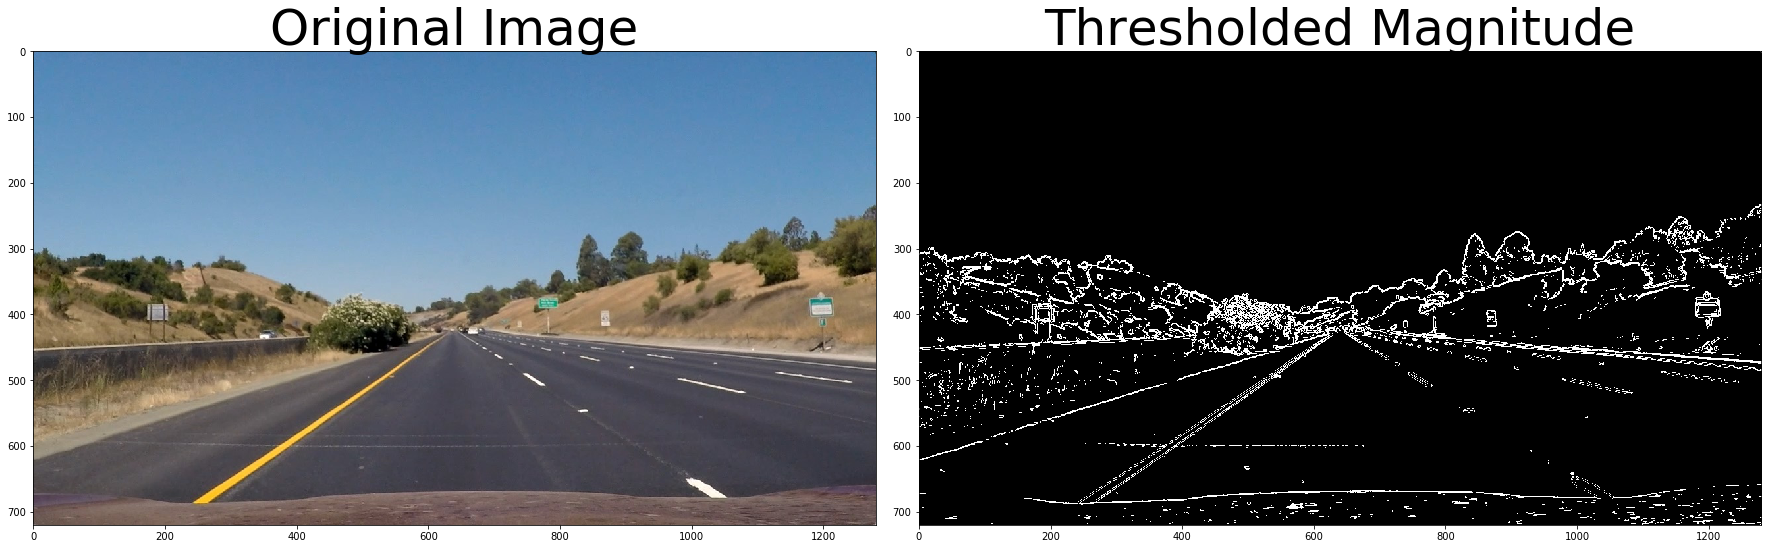

In [131]:
# Run Magnitude thresholding

mag_binary = mag_thresh(img, sobel_kernel=9, mag_thresh=(30, 100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(mag_binary, cmap='gray')
ax2.set_title('Thresholded Magnitude', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

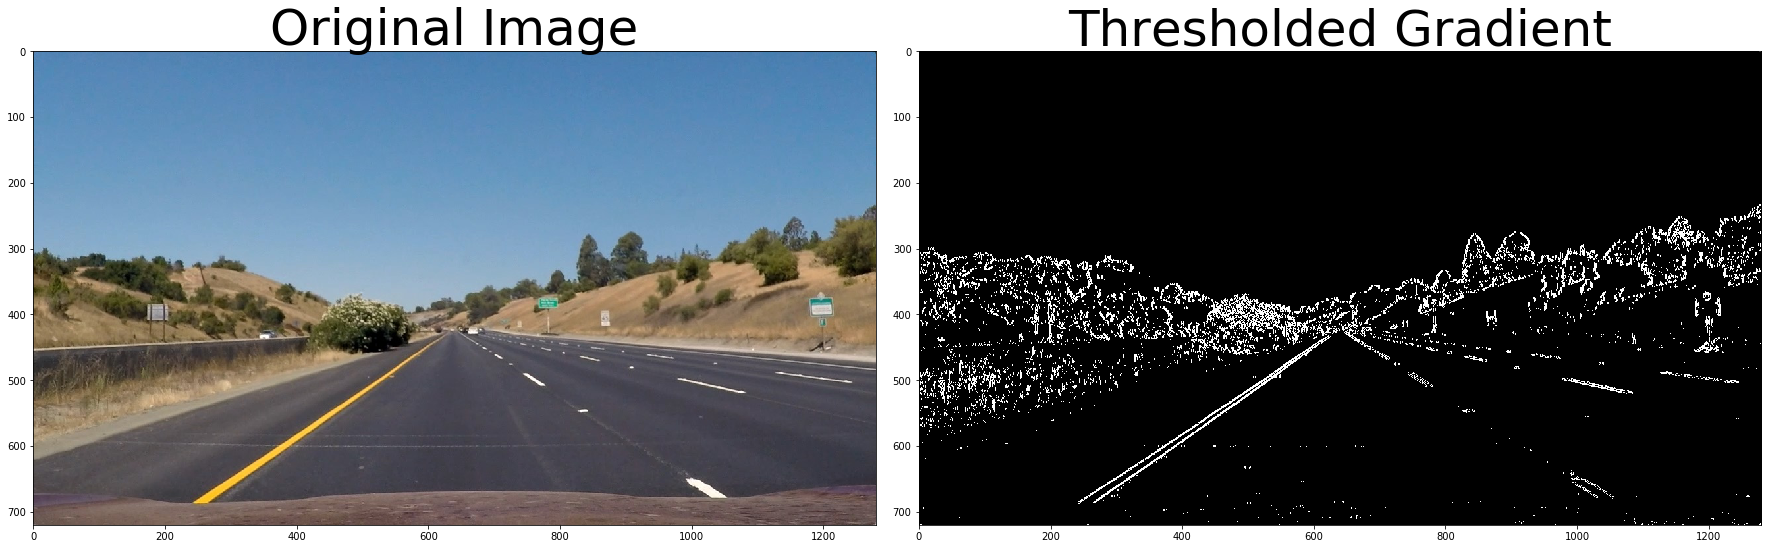

In [133]:
# Run the abs_sobel_thresh function

grad_binary = abs_sobel_thresh(img, orient='x', thresh = (20,100))
# Plot the result
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(grad_binary, cmap='gray')
ax2.set_title('Thresholded Gradient', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

## Combine different thresholding



max  255
min  0
combined.shape (720, 1280)
thresh_image.shape (720, 1280, 3)


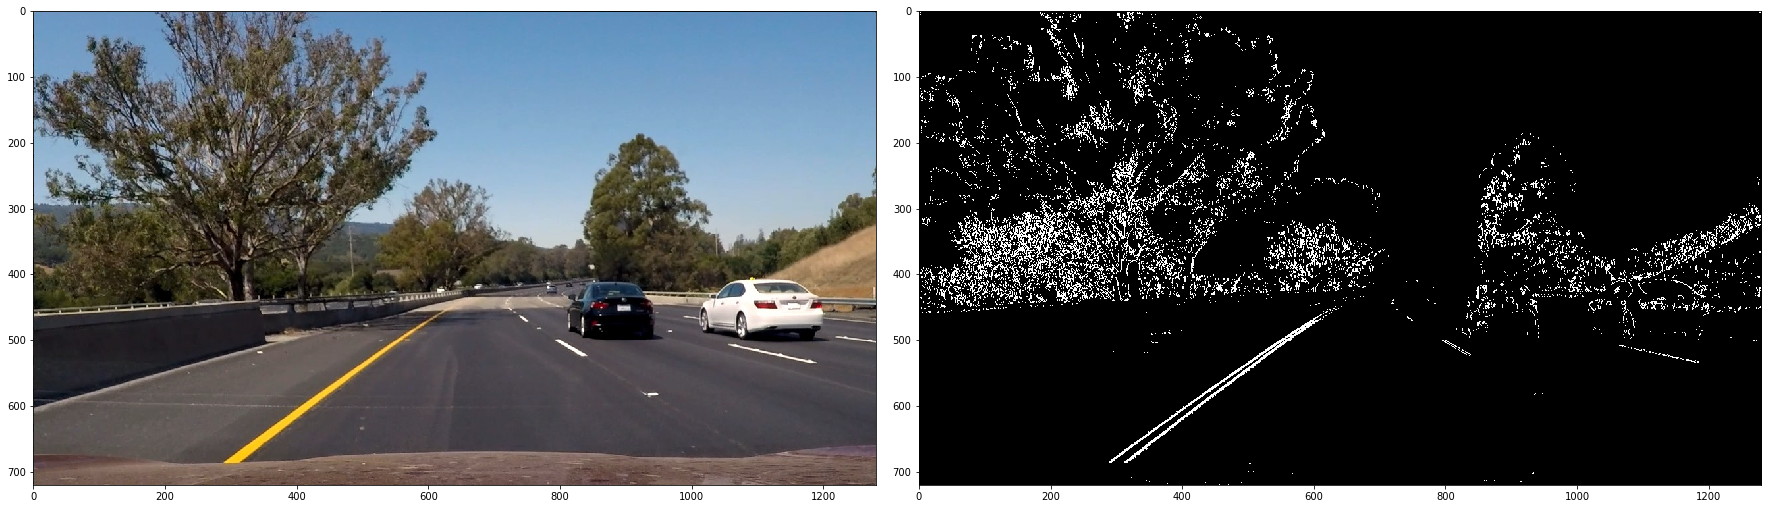

In [155]:
## Combine different thresholding
# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(8, 200))
#grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(0, 255))
#mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(0, 255))
#dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0, np.pi/2))
s_binary = hls_threshold(img, color_channel = 's', thresh=(70,255))
#l_binary = hls_threshold(img, color_channel = 'l', thresh=(0,1))
#h_binary = hls_threshold(img, color_channel = 'h', thresh=(0,1))


combined = np.zeros_like(dir_binary)
combined[(s_binary == 1) & (gradx==1)  ] = 1
print("combined.shape",combined.shape)

#combined = np.float32(combined *255)
thresh_image  = np.dstack((combined,combined,combined))
print("thresh_image.shape",thresh_image.shape)
plot_two_images(img, thresh_image)

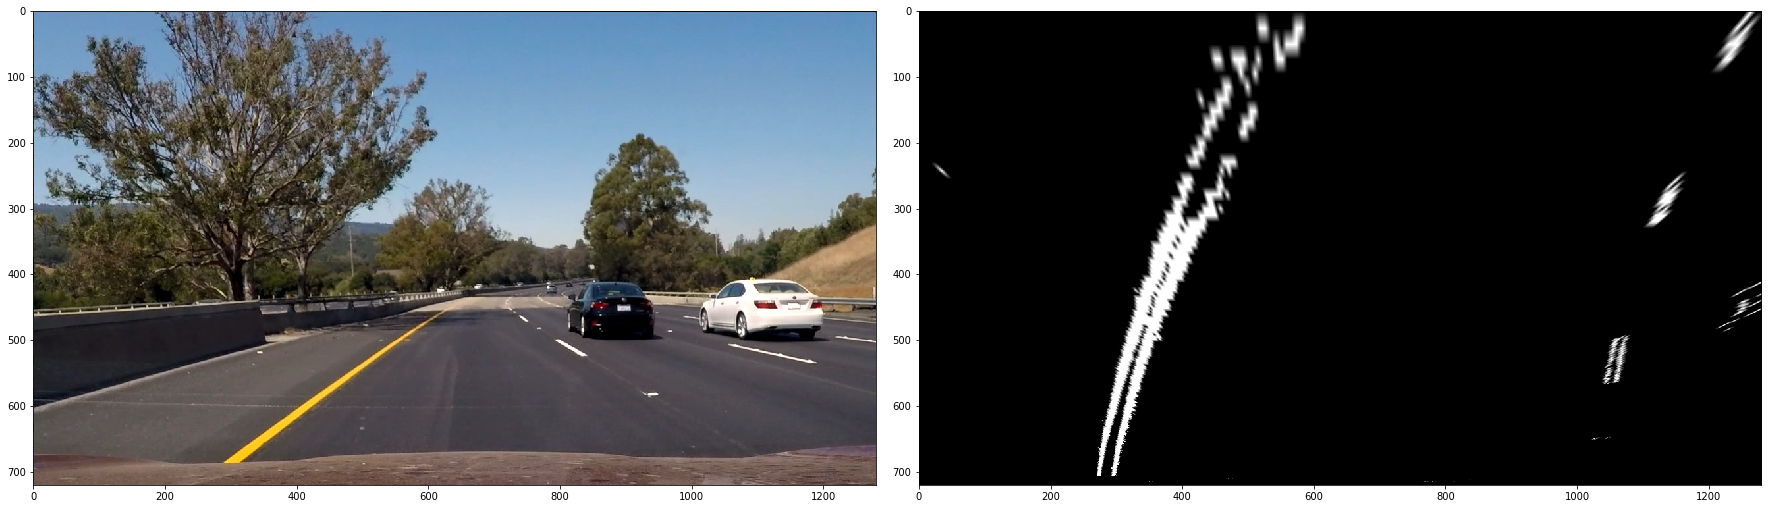

In [156]:
binary_warped = cv2.warpPerspective(combined, M, (gray.shape[::-1]) , flags=cv2.INTER_LINEAR)

plot_two_images(img, binary_warped)

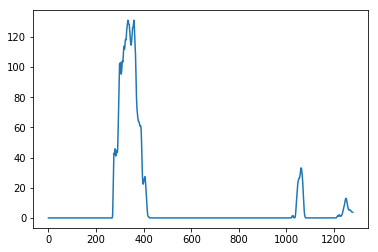

In [144]:
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)

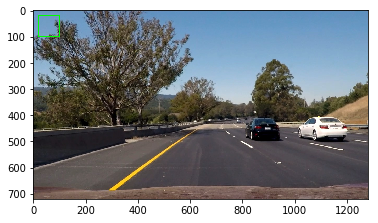

In [183]:
#out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
#x = plt.imshow(out_img)
out_img = cv2.rectangle(img,(20,20),(100,100),
    (0,255,0), 2) 
x = plt.imshow(out_img)

## Implement Sliding Windows and Fit a Polynomial


In [188]:
# Assuming you have created a warped binary image called "binary_warped"
# Take a histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]//2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]//nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
    #plt.imshow(out_img,cmap = 'gray')
    
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
    (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
out_img = np.float32(out_img)

plt.imsave('./figure2.jpg',out_img)

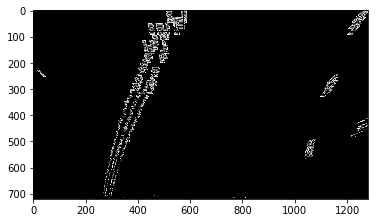

In [189]:
figure = plt.imread('./figure2.jpg')
plt.imshow(figure)

## Visualize

(720, 0)

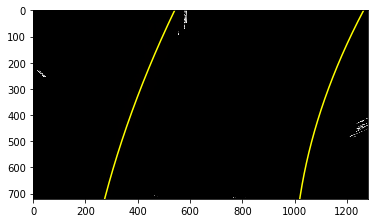

In [204]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)


## Visualize Part 2

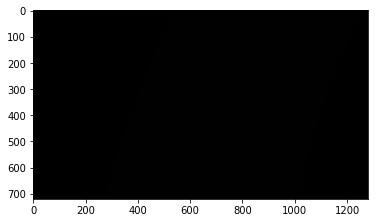

In [209]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
#cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
#cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))

left_line = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
right_line = np.array([np.flipud(np.transpose(np.vstack([right_fitx,ploty])))])
line_pts = np.hstack((left_line, right_line))
cv2.fillPoly(window_img, np.int_([line_pts]), (0,255, 0))

plt.imshow(window_img)
#plot_two_images(img, window_img)
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
#plt.imshow(result)
#plt.plot(left_fitx, ploty, color='yellow')
#plt.plot(right_fitx, ploty, color='yellow')
#plt.xlim(0, 1280)
#plt.ylim(720, 0)

In [ ]:
warped = cv2.warpPerspective(img, Minv, (gray.shape[::-1]) , flags=cv2.INTER_LINEAR)